In [95]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
from itertools import chain
import tensorflow_addons as tfa

In [96]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18370029663589686630
]
Num GPUs Available:  0


In [97]:
df = pd.read_csv('C:/Users/Rasmu/Downloads/ner_dataset.csv', encoding = "unicode-escape", error_bad_lines=False)
df = df[:100000]
df = df.fillna(method='ffill')
df.head()

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [98]:
#Create mapper for features

tag_vocab = np.unique(df['Tag']).tolist()
word_vocab = np.unique(df['Word']).tolist()

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

i_to_tag = {i:tag for  i, tag in enumerate(tag_vocab)}
tag_to_i = {tag:i for  i, tag in enumerate(tag_vocab)}

In [99]:
#Append index columns for words and tags and group dataframe by sentence

df['Word_index'] = df['Word'].map(word_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)

df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))

C:\Users\Rasmu\AppData\Local\Temp/ipykernel_22112/2204932765.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


In [100]:
max_tag = len(tag_vocab)
max_word = len(word_vocab)

tokens = df_grouped['Word_index'].tolist()
tags = df_grouped['Tag_index'].tolist()

max_length = max([len(s) for s in tokens])

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding='post', value= max_word - 1)


pad_tags = pad_sequences(tags, maxlen=max_length, dtype='int32', padding='post', value= tag_to_i["O"])
n_tags = len(tag_to_i)

pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=None, random_state=0)
train_tokens, test_tokens, train_tags, test_tags = train_test_split(tokens_,tags_,test_size = 0.3, random_state=0)

In [107]:
input_dim = len(word_vocab)+1

print(input_dim)

output_dim = 64
input_length = max([len(s) for s in df_grouped['Word_index'].tolist()])
n_tags = len(tag_vocab)

10923


In [102]:
root_logdir = os.path.join(os.curdir, "la_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
run_log_dir

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [105]:
from keras.models import Input, Model

input = layers.Input(shape=(max_length,))

model = layers.Embedding(len(i_to_word), output_dim=output_dim, input_length=input_length)(input)
model = layers.Bidirectional(layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(model)
model = layers.TimeDistributed(layers.Dense(n_tags, activation="softmax"))(model)

crf = tfa.layers.CRF(units=n_tags)
output = crf(model)

ner_model = Model(input, output)


adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Hyper params to change - learning rate, number of layers and neurons, activations functions

ner_model.compile(loss=tfa.layers.CRF.losses, optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
ner_model.summary()
plot_model(model)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 10923)]           0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 10923, 64)         699072    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 10923, 128)        66048     
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10923, 17)         2193      
_________________________________________________________________
crf_23 (CRF)                 [(None, 10923), (None, 10 629       
Total params: 767,942
Trainable params: 767,942
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/dow

In [106]:
%reload_ext tensorboard
%tensorboard --logdir=./la_logs --port=8888

history = ner_model.fit(train_tokens, np.array(train_tags), epochs=20, callbacks=[tensorboard_cb], verbose=1)


Reusing TensorBoard on port 8888 (pid 9056), started 3:35:41 ago. (Use '!kill 9056' to kill it.)

Epoch 1/20


ValueError: in user code:

    C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Rasmu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Rasmu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Rasmu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_5: expected shape=(None, 10923), found shape=(None, 70)


In [ ]:
y_pred = model.predict(test_tokens) #Calculates probability for each tag

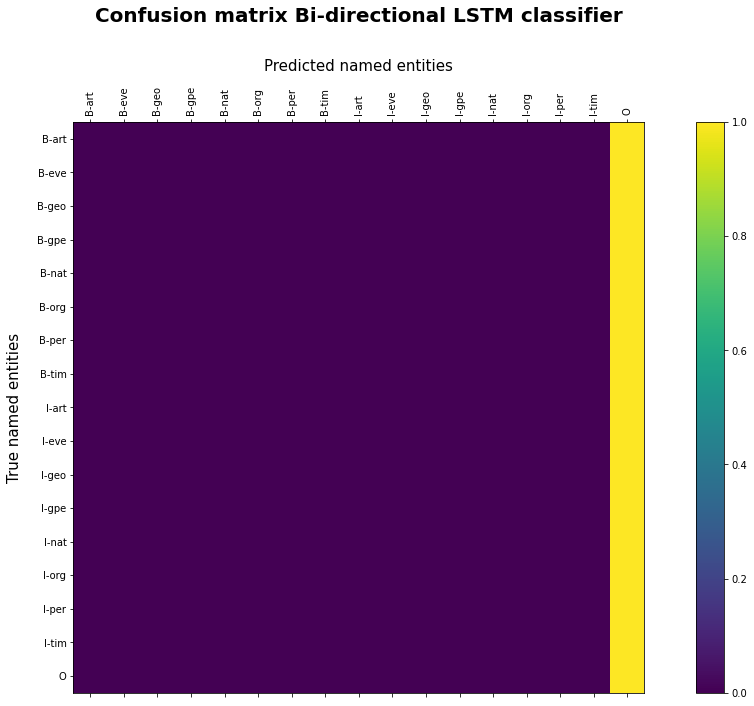

In [ ]:
y_classes = y_pred.argmax(axis=-1)
cm_true = y_classes.flatten()
cm_pred = np.array(test_tags).argmax(axis=-1).flatten()

cm = confusion_matrix(cm_pred, cm_true, normalize='true')
fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(len(tag_vocab)), tag_vocab, rotation=90)
plt.yticks(range(len(tag_vocab)), tag_vocab)
plt.show()